In [ ]:
!pip install geopandas

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import geopandas as gpd 
import sys

print('Matplotlib Version: ' + mpl.__version__)
print('NumPy Version: ' + np.version.full_version)
print('Python Version: ' + sys.version)

import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)

ModuleNotFoundError: No module named 'geopandas'

In [2]:
pd.set_option("display.max_row",100)
pd.set_option("display.max_column",70)
pd.set_option("display.precision", 5)

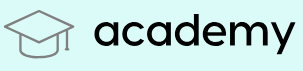

# <span class="bg-info">Sommaire du notebook</span>

1. __Introduction__
2. __Description__ du jeu de données
3. __Réduction__ du jeu de données
4. __Sélection/Analyse__ des indicateurs et __élimination__ des pays pauvres en données
5. __Mise à l'échelle et Score__
6. __Conclusion partielle__
7. __Prédiction__
8. __Conclusion finale__

# <span class="bg-info">1. Introduction</span>
## Projet d’expansion à l’international de l’entreprise academy

### Source : 
__EdStats__ Ce site web est le portail de la Banque mondiale pour les données concernant le secteur de l’éducation.
Le portail EdStats utilise des données provenant de sources externes :
-	Institut de statistique de l’UNESCO, 
-	Enquêtes ménage (ex. DHS, MICS, LSMS)
-	Evaluations internationales des acquis scolaires (ex. PISA, PIAAC, TIMSS, PIRLS) 
-	Evaluations régionales et nationales (ex. SAQMEC (Afrique australe et orientale), PASEC, LLECE, EGRA/EGMA) pour offrir une vue d’ensemble du paysage éducatif.

### Academy :
C'est une start-up de la EdTech, nommée Academy, qui propose des contenus de __formations en ligne__ pour un public de __niveau lycée et université.__

__Les questions à explorer :__

-	Quels sont les pays avec un fort potentiel de clients ?
-	Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
-	Dans quels pays l’entreprise doit-elle opérer en priorité ?

### Stratégie :

Après avoir vérifié __la cohérence du jeu de données__ proposé par EdStats, nous chercherons, parmi les 4000 indicateurs, les plus pertinents d'un point de vue:
- __éducatif__ : la population cible d'Academy est celle des 15-24 ans. Ce sont les indicateurs éducatifs relatifs à cette tranche d'âge, en rapport avec l'enseignement __secondaire__, qui retiendront notre attention.
- __numérique__ : l'accés à internet est primordial pour une formation en ligne.
- __économique__ : le niveau de vie de la population dans les différents pays sera à analyser.
- __démographique__ : les pays dans lesquels la tranche des 15-24 ans est importante seront à privilégier.

# <span class="bg-info">2. Description du jeu de données</span>

#### <span class="bg-success">2_1 Chargement du jeu de données et analyse pré-exploratoire</span>

In [3]:
data = pd.read_csv("EdStatsData.csv")

In [4]:
data.shape;

In [5]:
data.head(3);

In [6]:
data.tail(3);

In [7]:
data.dtypes.value_counts();

In [8]:
data.describe(exclude=[np.number]);

In [9]:
data["Country Name"].nunique();

#### <span class="bg-success">2_2 Valeurs manquantes</span>

In [10]:
#Fonction pour visualiser les valeurs manquantes par lignes, avec gradient de couleur
def get_missing_values(data):
    
    values = data.isnull().sum()
    percentage = 100 * data.isnull().sum() / len(data)
    table = pd.concat([values, percentage.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
    
    return table[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending = False).style.background_gradient('Greens')
get_missing_values(data);

Visualisation des données du dataset (en noir) et des valeurs manquantes (en saumon)

<AxesSubplot:>

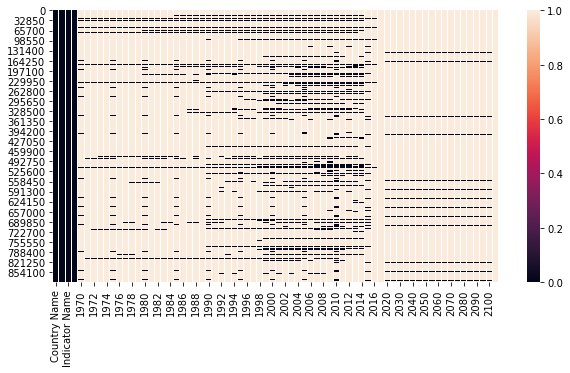

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isna())

#### <span class="bg-success">2_3 Récapitulatif sur l'analyse du jeu de données</span>

__Identification de la target__ : "Country Name"

__Nombre de lignes et de colonnes__ : 886 930 lignes, 70 colonnes

__Types de variables__ : 4 variables qualitatives et 66 variables quantitatives

__Identification des valeurs manquantes__ : entre 73 et 100 % de valeurs manquantes/année, peu de données après 2015 : 2016 et 2017 presque vides, absence des années 2018 et 2019. Les données de 2020 (et au-delà) sont des données de projections.

__<span class="text-danger">Le jeu de données comportent de nombreuses valeurs manquantes.</span>__
Seules les 4 premières colonnes sont entièrement remplies. Une réduction de la taille de ce jeu de données est possible et nécessaire pour répondre à nos questions.

# <span class="bg-info">3. Réduction du jeu de données</span>

#### <span class="bg-success">3_1 : Elimination des lignes renseignées uniquement pour les 4 premières valeurs objets</span> 

In [12]:
df_epure = data.copy()

In [13]:
df_epure = data.dropna(thresh = 5)
# Copie pour analyse avec double lissage exponentiel/ 7. Prédictions
df_double_lissage = df_epure.copy()

La taille du jeu de données est à présent de __357 405 lignes et 70 colonnes.__

#### <span class="bg-success">3_2 : Sélection de la plage temporelle optimum</span>

Pour trouver les pays à fort potentiel clients, les colonnes concernant les années avant 2009 ne nous paraissent pas pertinentes. Nous avons de plus constaté que les informations relatives aux années avant 2000 étaient amputées de nombreuses valeurs manquantes. Nous éliminons donc les colonnes de 1970 à 2009. Nous faisons de même pour la plage temporelle de 2016 à 2100. Peu de données disponibles après 2015 dans le jeu de données et les années après 2020 sont des données de projection. Nous retirons aussi la colonne aberrante "Unnamed: 69"

In [14]:
col_to_drop = ['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978','1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987','1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996','1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005','2006', '2007', '2008', '2009','2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045','2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090','2095', '2100', 'Unnamed: 69']
df_epure = df_epure[df_epure.columns.drop(col_to_drop)]

#### <span class="bg-success">3_3 : Elimination des zones géographiques présentes au début du jeu de données</span> 

In [15]:
df_pays = df_epure.copy()
df_pays = df_pays.set_index("Country Name")
df_pays.drop(['Arab World', 'East Asia & Pacific','East Asia & Pacific (excluding high income)', 'Euro area','Europe & Central Asia','Europe & Central Asia (excluding high income)', 'European Union','Heavily indebted poor countries (HIPC)', 'High income','Latin America & Caribbean','Latin America & Caribbean (excluding high income)','Least developed countries: UN classification','Low & middle income', 'Low income', 'Lower middle income','Middle East & North Africa','Middle East & North Africa (excluding high income)','Middle income', 'North America', 'OECD members', 'South Asia','Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)','Upper middle income', 'World'], inplace = True)
df_pays = df_pays.reset_index()

#### <span class="bg-success">3_4 : Visualisation des données du dataset (en noir) et des valeurs manquantes (en saumon) après réduction</span> 

<AxesSubplot:ylabel='Country Name'>

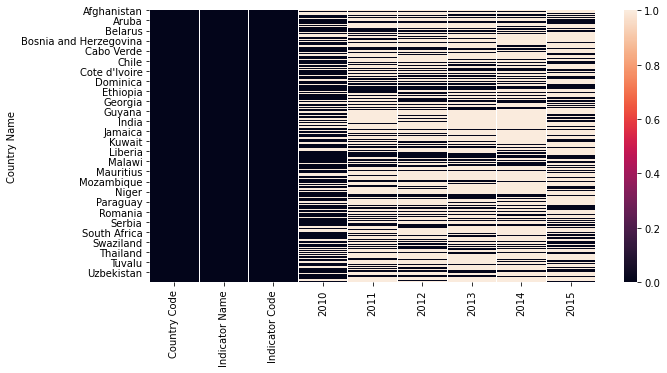

In [16]:
df_pays = df_pays.set_index("Country Name")
plt.figure(figsize=(10,5))
sns.heatmap(df_pays.isna())

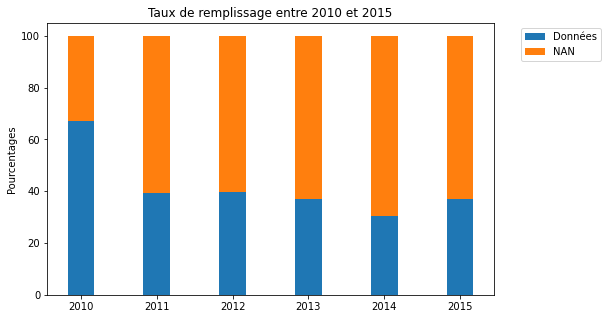

In [17]:
# Graphique taux de remplissage/NAN en %
annees = ['2010', '2011', '2012', '2013', '2014', "2015"]
taux_remplissages = [67.105630, 39.482552, 39.770981, 36.969431, 30.349361, 37.136915]
taux_nan= [32.894370, 60.517448, 60.229019, 63.030569, 69.650639, 62.863085]
width = 0.35      

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(annees, taux_remplissages, width, label='Données')
ax.bar(annees, taux_nan, width, bottom=taux_remplissages, label='NAN')

ax.set_ylabel('Pourcentages')
ax.set_title('Taux de remplissage entre 2010 et 2015')
ax.legend(bbox_to_anchor=(1.05, 1),loc = 2)

plt.show()

Cette partie du jeu de données, forte en valeurs manquantes, est cependant mieux fourni en données. __32% < % NAN < 70%__. 

L'année __<span class="text-danger">2010</span>__ est la plus fournie en données. 
L'année __<span class="text-danger">2015</span>__, l'année la plus proche du présent, est exploitable.

# <span class="bg-info">4. Sélection/Analyse des indicateurs et élimination de pays</span>

#### <span class="bg-success">4_1 : Tests de corrélation des indicateurs potentiellement pertinents__</span>

Un indicateur __démographique__ : __"SP.POP.1524.TO.UN"__ 
Deux indicateurs __éducatifs__ : __"BAR.SEC.CMPT. 1519.ZS" et "BAR.SEC.CMPT.2024.ZS"__ 
Un indicateur __économique__ : __"NY.GDP.PCAP.CD"__
Un indicateur __numérique__ : __"IT.NET.USER.P2"__ 

<AxesSubplot:xlabel='Indicator Code', ylabel='Indicator Code'>

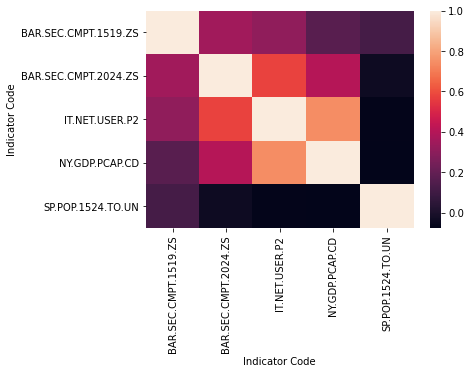

In [18]:
# Matrice de corrélation avec les 5 indicateurs potentiellement pertinents.
indicators_to_keep = ["SP.POP.1524.TO.UN", "BAR.SEC.CMPT.1519.ZS", "BAR.SEC.CMPT.2024.ZS", "NY.GDP.PCAP.CD","IT.NET.USER.P2"]
df_5_indicateurs_test = df_pays[df_pays['Indicator Code'].isin(indicators_to_keep)]
df_pivot_5_indicateurs_test = df_5_indicateurs_test.pivot_table(index=['Country Name'], columns=['Indicator Code'], values= '2010')
sns.heatmap(df_pivot_5_indicateurs_test.corr())

L'indicateur numérique (Internet) et l'indicateur économique (PIB PPA) sont fortement corrélés. Les 2 indicateurs éducatifs (populations de lycéens et d'étudiants) sont corrélés, et une corrélation existe également entre l'indicateur population étudiante et l'indicateur numérique. Le choix est fait de retenir 3 indicateurs sur 5.

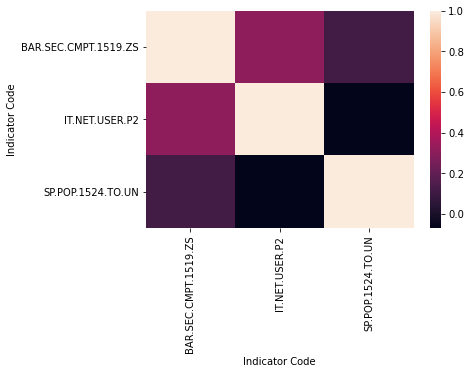

In [19]:
#Matrice de corrélation des 3 indicateurs retenus
indicators_to_keep = ["SP.POP.1524.TO.UN", "BAR.SEC.CMPT.1519.ZS","IT.NET.USER.P2"]
df_3_indicateurs_test = df_pays[df_pays['Indicator Code'].isin(indicators_to_keep)]
df_pivot_3_indicateurs_test = df_3_indicateurs_test.pivot_table(index=['Country Name'], columns=['Indicator Code'], values= '2010')
sns.heatmap(df_pivot_3_indicateurs_test.corr())
df_pivot_3_indicateurs_test;

#### <span class="bg-success">4_2 : Indicateurs retenus : </span>

__"SP.POP.1524.TO.UN"__ (démographique : population cible), 
    
__"BAR.SEC.CMPT.1519.ZS"__ (éducatif : population lycéenne),
    
__"IT.NET.USER.P2"__ (numérique : internet). 

#### <span class="bg-success">4_3 : Analyse univariée et visualisation des 3 indicateurs retenus</span> 

In [20]:
#Tableaux créés pour chaque indicateur, pour une analyse univariée
df_3_indicateurs_retenus = df_3_indicateurs_test.copy() 
df_education_Barro_Lee = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "BAR.SEC.CMPT.1519.ZS")].pivot_table(index=['Country Name'], columns=['Indicator Code' ], values= '2010')
df_internet = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "IT.NET.USER.P2")].pivot_table(index=['Country Name'], columns=['Indicator Code' ], values= ['2010', '2015'])
df_population_15_24 = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "SP.POP.1524.TO.UN")].pivot_table(index=['Country Name'], columns=['Indicator Code' ], values= ['2010','2015'])

In [21]:
df_education_Barro_Lee.describe();

In [22]:
df_internet.describe();

In [23]:
df_population_15_24.describe();

In [24]:
df_education_graph_Barro_Lee = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "BAR.SEC.CMPT.1519.ZS")]
df_internet_graph = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "IT.NET.USER.P2")]
df_population_15_24_graph = df_3_indicateurs_retenus.loc[(df_3_indicateurs_retenus['Indicator Code'] == "SP.POP.1524.TO.UN")]

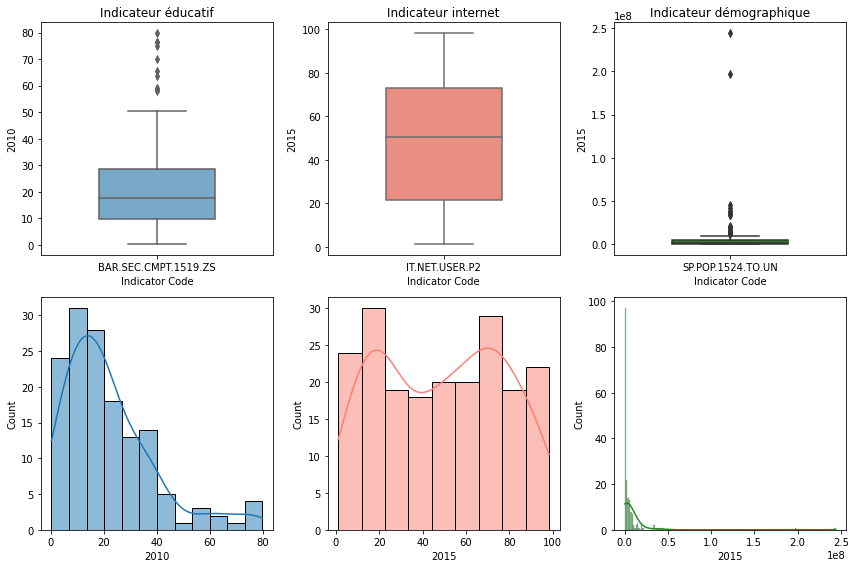

In [25]:
#Graphiques statistiques sur les 3 indicateurs  
plt.figure(figsize = (12, 8))

plt.subplot(2,3,1)
plt.title('Indicateur éducatif')
sns.boxplot( x=df_education_graph_Barro_Lee["Indicator Code"], y=df_education_graph_Barro_Lee["2010"], palette = "Blues", width=0.5)

plt.subplot(2,3,2)
plt.title('Indicateur internet')
sns.boxplot( x=df_internet_graph["Indicator Code"], y=df_internet_graph["2015"], color ="salmon", width=0.5)

plt.subplot(2,3,3)
plt.title('Indicateur démographique')
sns.boxplot( x=df_population_15_24_graph["Indicator Code"], y=df_population_15_24_graph["2015"], color = "forestgreen", width=0.5)

plt.subplot(2,3,4)
sns.histplot(df_education_graph_Barro_Lee["2010"], kde = True)

plt.subplot(2,3,5)
sns.histplot(df_internet_graph["2015"], kde = True, color = "salmon" )

plt.subplot(2,3,6)
sns.histplot(df_population_15_24_graph["2015"], kde = True, color = "forestgreen")

plt.tight_layout()

Notons la présence d'outliers dans les indicateurs BAR SEC CMPT 1519 ZS (éducatif) et IT.NET.USER.P2 (Internet).

#### <span class="bg-success">4_5 : Elimination des pays pauvres en données / aux indicateurs</span> 

In [46]:
#Calcul du poucentage de valeurs manquantes par pays pour les 3 indicateurs retenus
df_pivot_indicateurs_retenus = df_3_indicateurs_test.pivot_table(index=['Country Name'], columns=['Indicator Code'], values= ['2010','2015'])
df_pivot_indicateurs_retenus["NAN"] =((df_pivot_indicateurs_retenus.isna().sum(axis =1)/df_pivot_indicateurs_retenus.columns.shape) * 100)
df_pivot_indicateurs_retenus[df_pivot_indicateurs_retenus["NAN"]>= 0].sort_values(by = ["NAN"])
df_NAN = df_pivot_indicateurs_retenus[df_pivot_indicateurs_retenus["NAN"]>= 20].sort_values(by = ["NAN"])
df_NAN;

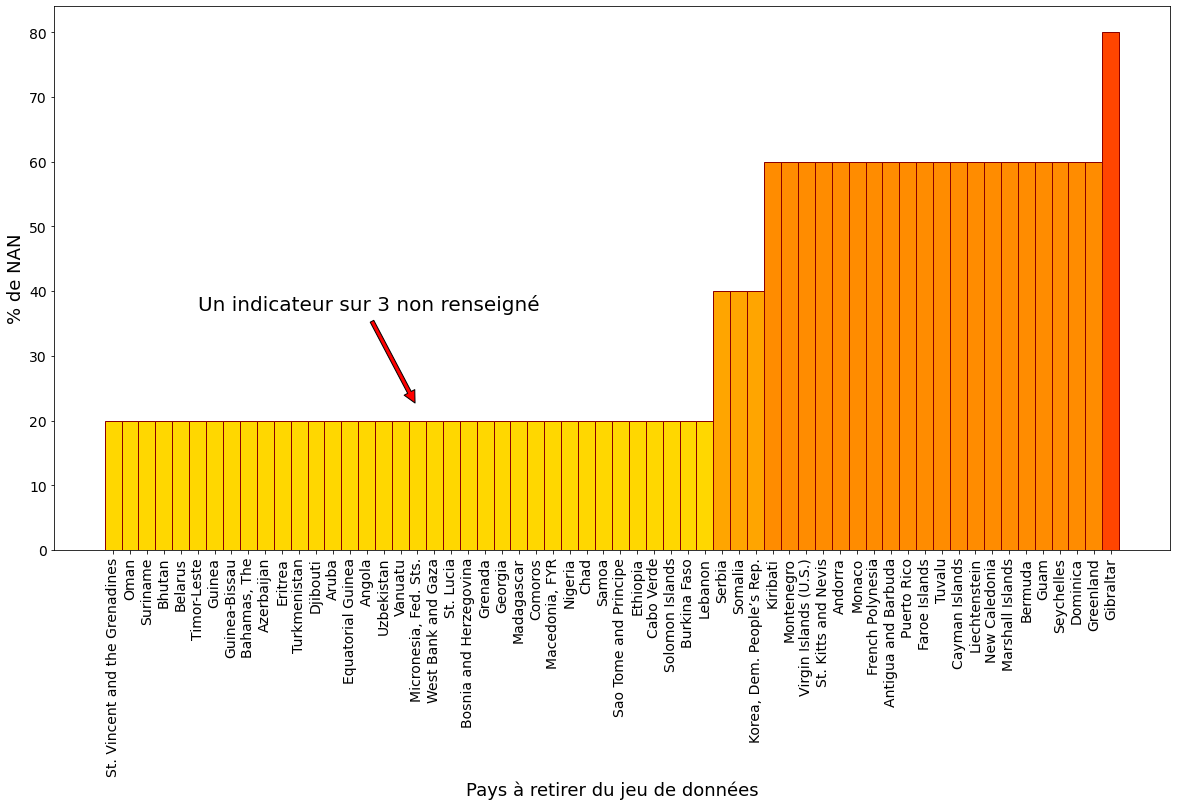

In [27]:
#Graphique permettant de visualiser les pays à retirer (il manque au moins 1 indicateur sur 3)
pays = df_NAN.index
pays1 = df_NAN["NAN"][df_NAN["NAN"] == 20].index
pays2 = df_NAN["NAN"][df_NAN["NAN"] == 40].index
pays3 = df_NAN["NAN"][df_NAN["NAN"] == 60].index
pays4 = df_NAN["NAN"][df_NAN["NAN"] == 80].index
fig = plt.figure()
fig.set_size_inches(20,10)
plt.xlabel('Pays à retirer du jeu de données',fontsize=18, color='black' )
plt.ylabel('% de NAN',fontsize=18 )
plt.xticks(rotation= 90, fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('Un indicateur sur 3 non renseigné',fontsize=20, xy=(18, 22), xytext=(5, 37), arrowprops = dict(facecolor='red', shrink=0.05),)

p1 = plt.bar(pays1, df_NAN["NAN"][df_NAN["NAN"] == 20] , width = 1, color='gold', edgecolor = "darkred")
p2 = plt.bar(pays2, df_NAN["NAN"][df_NAN["NAN"] == 40] , width = 1, color='orange', edgecolor = "darkred")
p3 = plt.bar(pays3, df_NAN["NAN"][df_NAN["NAN"] == 60] , width = 1, color='darkorange', edgecolor = "darkred")
p4 = plt.bar(pays4, df_NAN["NAN"][df_NAN["NAN"] == 80] , width = 1, color='orangered',edgecolor = "darkred" )

In [28]:
#Création du dataset comprenant les 3 indicateurs retenus, et les pays candidats
df_pays = df_pays.filter(items = ['Country Name','Country Code','Indicator Code', '2010', '2015'])
indicators_to_keep = ["BAR.SEC.CMPT.1519.ZS","SP.POP.1524.TO.UN","IT.NET.USER.P2"]
df_indicateurs = df_pays[df_pays['Indicator Code'].isin(indicators_to_keep)]
df_indicateurs = df_indicateurs.dropna(thresh =3)
df_indicateurs = df_indicateurs.pivot_table(index=['Country Name'], columns=['Indicator Code'], values= '2010').dropna()
df_indicateurs;

Nous retirons de la liste des candidats les pays pauvres en données. Il reste __143 pays__ candidats.

## <span class="bg-info">5 : Mise à l'échelle du jeu de données et score <span> 
    
Nos indicateurs retenus sont dans des unités variées, une mise à l'échelle semble pertinente avant de chercher le score de chaque pays candidat.
Deux indicateurs retenus présentent des outliers, à surveiller.
Après test, nous utiliserons __StandardScaler__ ou __MinMaxScaler__ pour mettre à l'échelle notre jeu de données.

#### <span class="bg-success">5_1 : Mise à l'échelle du jeu de données </span> 

In [29]:
#Fonction pour visualiser les courbes de distribution des 3 indicateurs après mise à l'échelle.
import matplotlib.patches as mpatches
def plotGraph(pscaled_df):
    fig, ax = plt.subplots(1, figsize=(16, 6))
    fig.suptitle("Après mise à l'échelle", fontsize=15)
    for col in pscaled_df.columns:
        sns.kdeplot(pscaled_df[col])
    blue_patch = mpatches.Patch(color='blue', label='Indicateur éducatif BAR.SEC.CMPT.1519.ZS ')
    orange_patch = mpatches.Patch(color='orange', label='Indicateur internet IT.NET.USER.P2')
    green_patch = mpatches.Patch(color='green', label='Indicateur démographique SP.POP.1524.TO.UN')
    plt.legend(handles=[blue_patch,orange_patch, green_patch])
    plt.show()

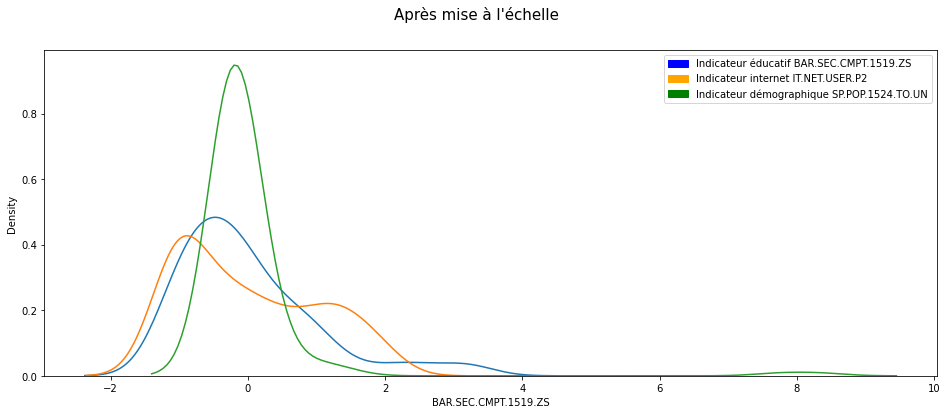

In [30]:
#Mise à l'échelle avec StandardScaler()
scaler = StandardScaler()
keepCols = ['BAR.SEC.CMPT.1519.ZS','IT.NET.USER.P2','SP.POP.1524.TO.UN']
df_scaled_indicateurs_standard = scaler.fit_transform(df_indicateurs[keepCols])
df_scaled_indicateurs_standard = pd.DataFrame(df_scaled_indicateurs_standard, columns = keepCols)
plotGraph(df_scaled_indicateurs_standard)

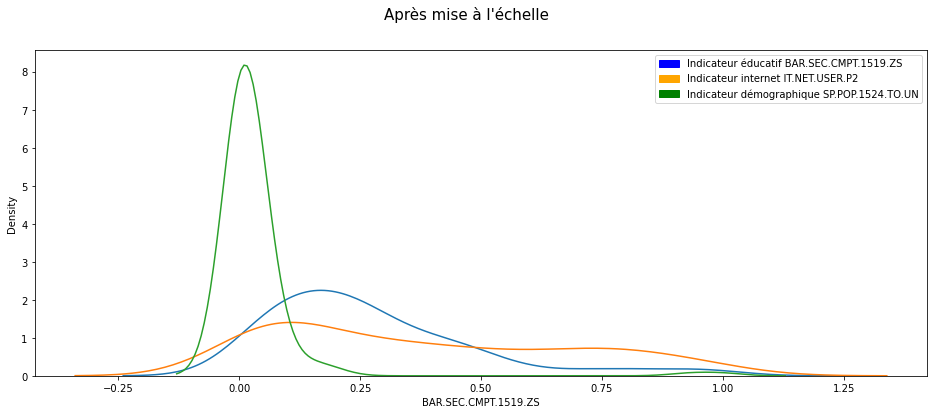

In [31]:
#Mise à l'échelle avec MinMaxScaler()
scaler = MinMaxScaler()
keepCols = ['BAR.SEC.CMPT.1519.ZS','IT.NET.USER.P2','SP.POP.1524.TO.UN']
df_scaled_indicateurs = scaler.fit_transform(df_indicateurs[keepCols])
df_scaled_indicateurs = pd.DataFrame(df_scaled_indicateurs, columns = keepCols)
plotGraph(df_scaled_indicateurs)

Nous avions repéré la présence d'outliers dans deux indicateurs. __La mise à l'échelle avec MinMaxScaler() semble plus appropriée.__

In [32]:
df_scaled_indicateurs["Country Name"] = df_indicateurs.index

#### <span class="bg-success">5_2 : Score</span> 

In [33]:
#Fonction de pondération pour calculer le score de chaque pays candidat.
def ponderation(row):
    return (row['BAR.SEC.CMPT.1519.ZS'] * 2 + row['IT.NET.USER.P2'] * 3 + row['SP.POP.1524.TO.UN'])   

In [34]:
df_scaled_indicateurs["Score"] = df_scaled_indicateurs.apply(ponderation, axis=1)
df_scaled_indicateurs= df_scaled_indicateurs.sort_values(by="Score", ascending = False)

#### <span class="bg-success">5_3 : Visualisation du score</span> 

In [35]:
#Importation du dataset des pays du monde de geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
#Corrections apportées car certains pays ne sont pas nommés de la même façon dans les 2 tableaux.
world.loc[world.index[[4,11,17,18, 149,66,67,153,163,80,107,105,152,108,40,157,96]], 'name'] = ["United States", "Congo, Dem. Rep.","Dominican Republic","Russian Federation","Brunei Darussalam","Central African Republic","Congo, Rep.","Czech Republic","Egypt, Arab Rep.","Gambia, The","Iran, Islamic Rep.","Kyrgyz Republic","Slovak Republic","Syrian Arab Republic","Venezuela, RB", "Yemen, Rep.","Korea, Rep."]

In [36]:
geomap_df = world.merge(df_scaled_indicateurs, left_on = 'name', right_on = 'Country Name')[['geometry','Country Name','Score']]

<AxesSubplot:>

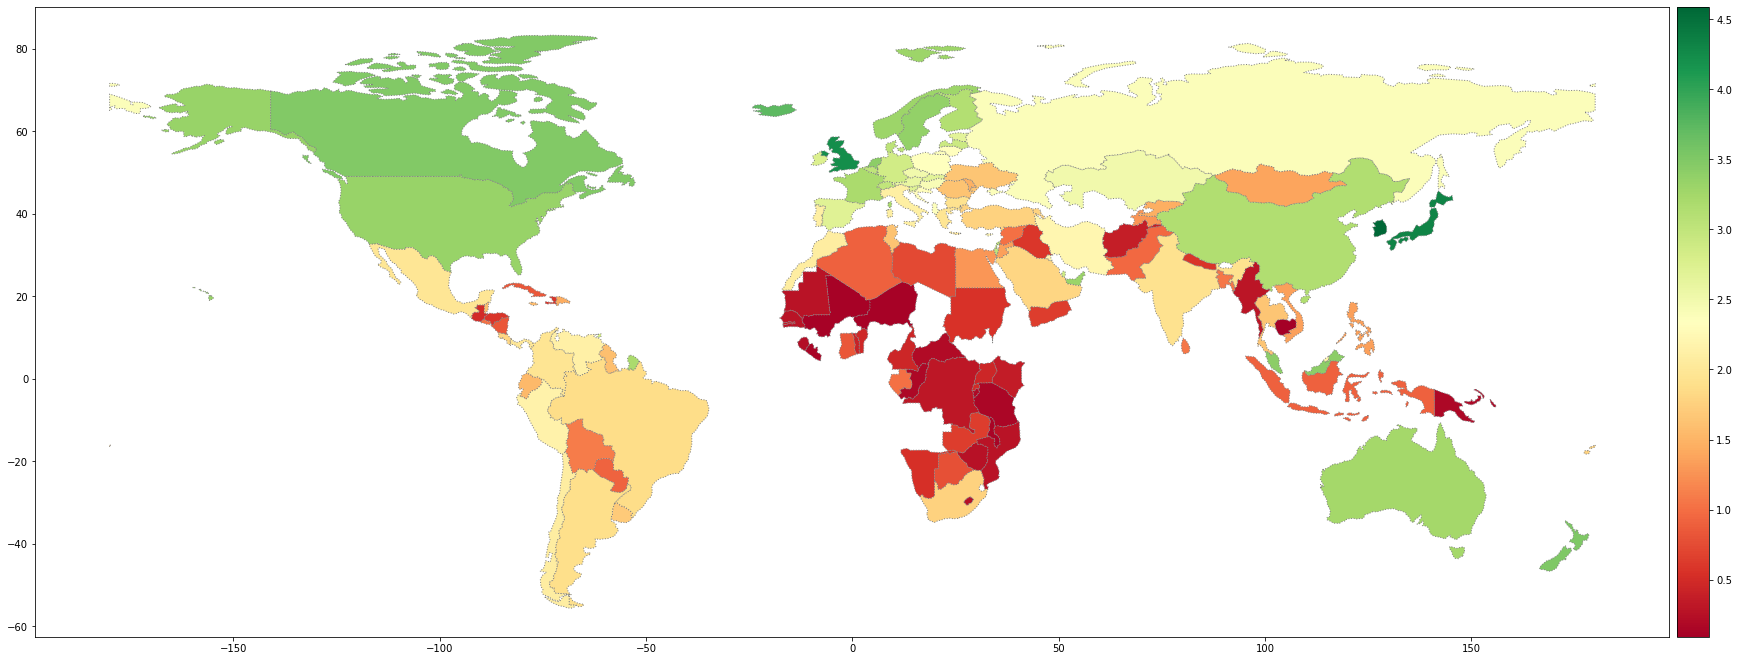

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
fig.set_size_inches(30,18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
geomap_df.plot(column=geomap_df['Score'], legend = True, ax=ax, cax=cax, cmap='RdYlGn',linestyle=":",edgecolor='grey' )

## <span class="bg-info">6 : Conclusion partielle<span> 

In [38]:
#Tableau des 12 pays condidats les mieux notés
df_score_top_10 = df_scaled_indicateurs.filter(items =["Country Name", "Score"])
df_score_top_10 = df_score_top_10.iloc[0:12]
df_score_top_10["Place"] = range(1,13)
df_score_top_10.set_index("Country Name")

,Score,Place
Country Name,,
"Korea, Rep.",4.58868,1
Japan,4.32173,2
"Hong Kong SAR, China",4.31471,3
United Kingdom,4.23593,4
Singapore,4.19717,5
Iceland,3.74366,6
New Zealand,3.51642,7
Canada,3.48985,8
Netherlands,3.42874,9


<span class="bg-danger">Trois zones géographiques se distinguent : __l'Asie du Sud Est, l'Amérique du Nord et l'Europe de l'Ouest.__<span> 
    
Une analyse prédictive menée sur ces 12 pays va nous aider à proposer __une liste réduite à 3 pays.__ 

## <span class="bg-info">7 : Prédictions<span> 

Le code complet ayant permis la réalisation des graphiques est disponible dans le notebook __"P2_02_notebook_Prédictions"__ joint au dossier.

#### <span class="bg-success">7_1 : Indicateur à prédire : SP.POP.1524.TO.UN / 12 pays retenus / plage temporelle 2000 à 2015 </span> 

In [39]:
#Sélection du tableau : Indicateur à prédire SP.POP.1524.TO.UN /12 pays retenus/ plage temporelle 2000 à 2015
col_a_enlever = ['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978','1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987','1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996','1997', '1998', '1999','2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045','2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090','2095', '2100', 'Unnamed: 69']
df_double_lissage = df_double_lissage[df_double_lissage.columns.drop(col_a_enlever)]
df_double_lissage = df_double_lissage.loc[(df_double_lissage['Indicator Code'] == "SP.POP.1524.TO.UN")]
col_a_enlever_2 = ['Country Code', 'Indicator Name', 'Indicator Code']
df_double_lissage = df_double_lissage[df_double_lissage.columns.drop(col_a_enlever_2)]
pays_a_garder = df_score_top_10["Country Name"].unique()
df_double_lissage  = df_double_lissage [df_double_lissage['Country Name'].isin(pays_a_garder)]
df_double_lissage.isna().sum();

Aucune valeur manquante dans la sélection.

#### <span class="bg-success">7_2 : Méthode de prédiction : le double lissage exponentiel </span>  cf notebook "P2_02_notebook_Prédictions"

Nous utilisons la fonction Lissage exponentiel double comme méthode de lissage générale et pour effectuer des prévisions à court terme (sur l'année 2016). Nos données présentent une tendance, mais pas de composante de saisonnalité. 

Voici les graphiques obtenus pour nos 12 pays candidats. Nous les étudions d'abord __un par un__ sur la plage temporelle allant de 2000 (0 sur le graphique) à 2016 (16 sur le graphique) avant de comparer l'évolution de leur population cible (19-24 ans) sur un même graphique. __L'année 2016 est l'année prédite__ par la méthode de lissage exponentielle. Les pays sont classés par ordre décroissant du score obtenu lors du classement.

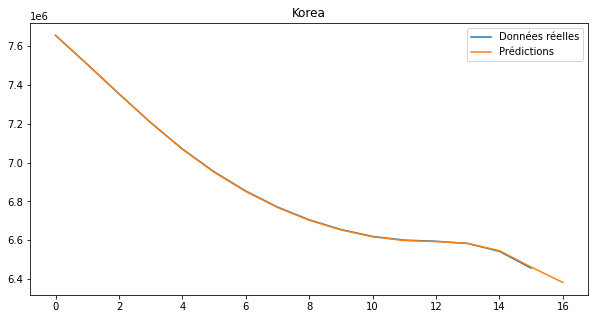
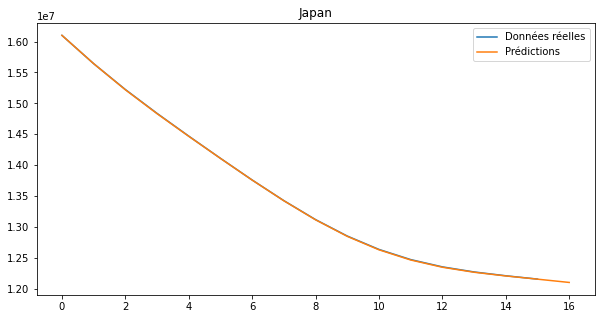
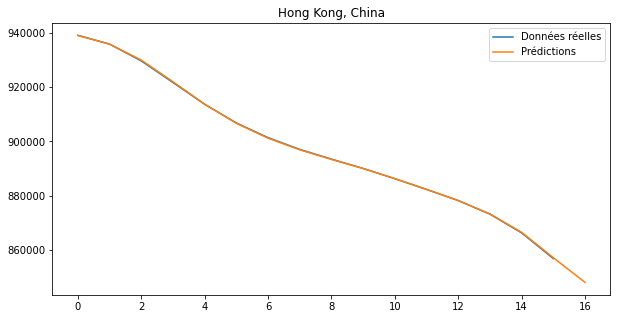
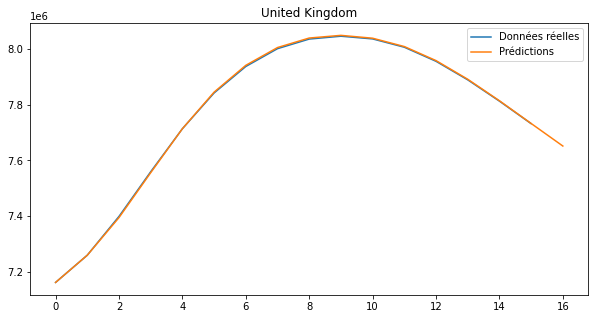
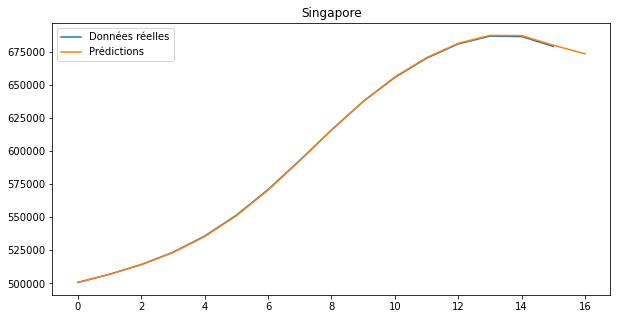
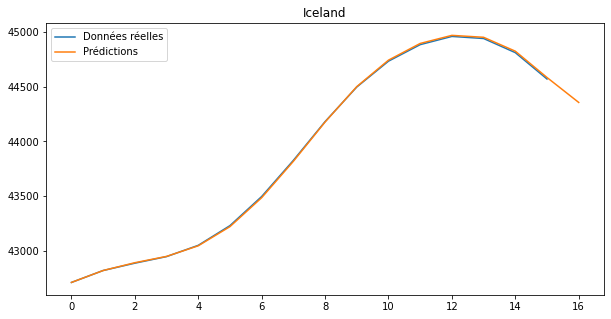
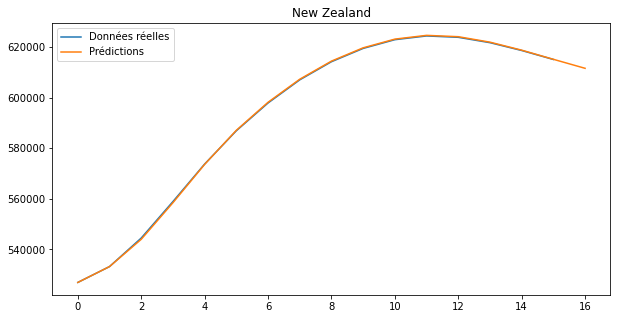
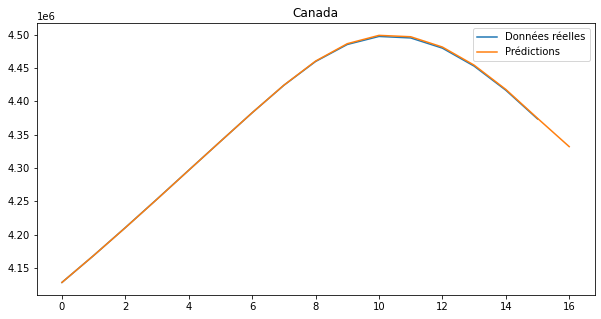
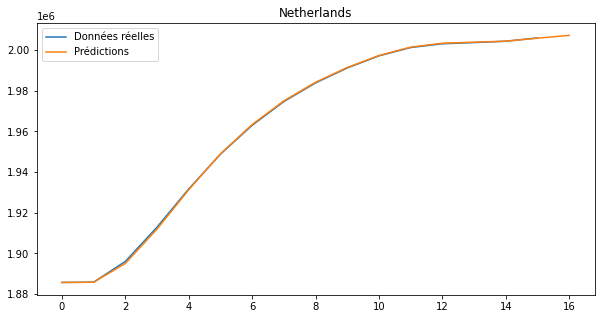
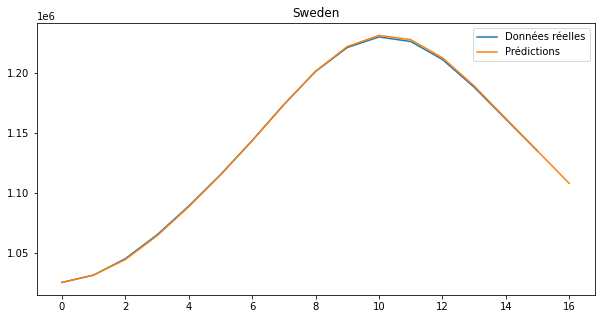
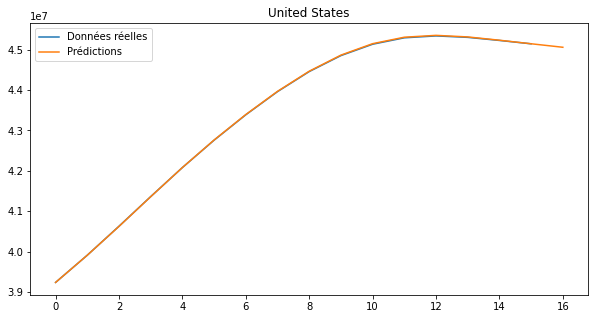

Seuls __deux pays observent une tendance à la hausse de leur population des 19-24 ans : les Pays Bas et la Malaisie.__ Ce que nous allons pouvoir vérifier sur le graphique ci-dessous qui regroupe les 12 pays.

Ce graphique est basé sur __le calcul du pourcentage d'augmentation ou de diminution de la population des 19-24 ans__ dans chacun dans 12 pays, entre deux années consécutives, sur un plage temporelle réduite par rapport aux graphiques précédents : de __2010 à 2016__ (année prédite).

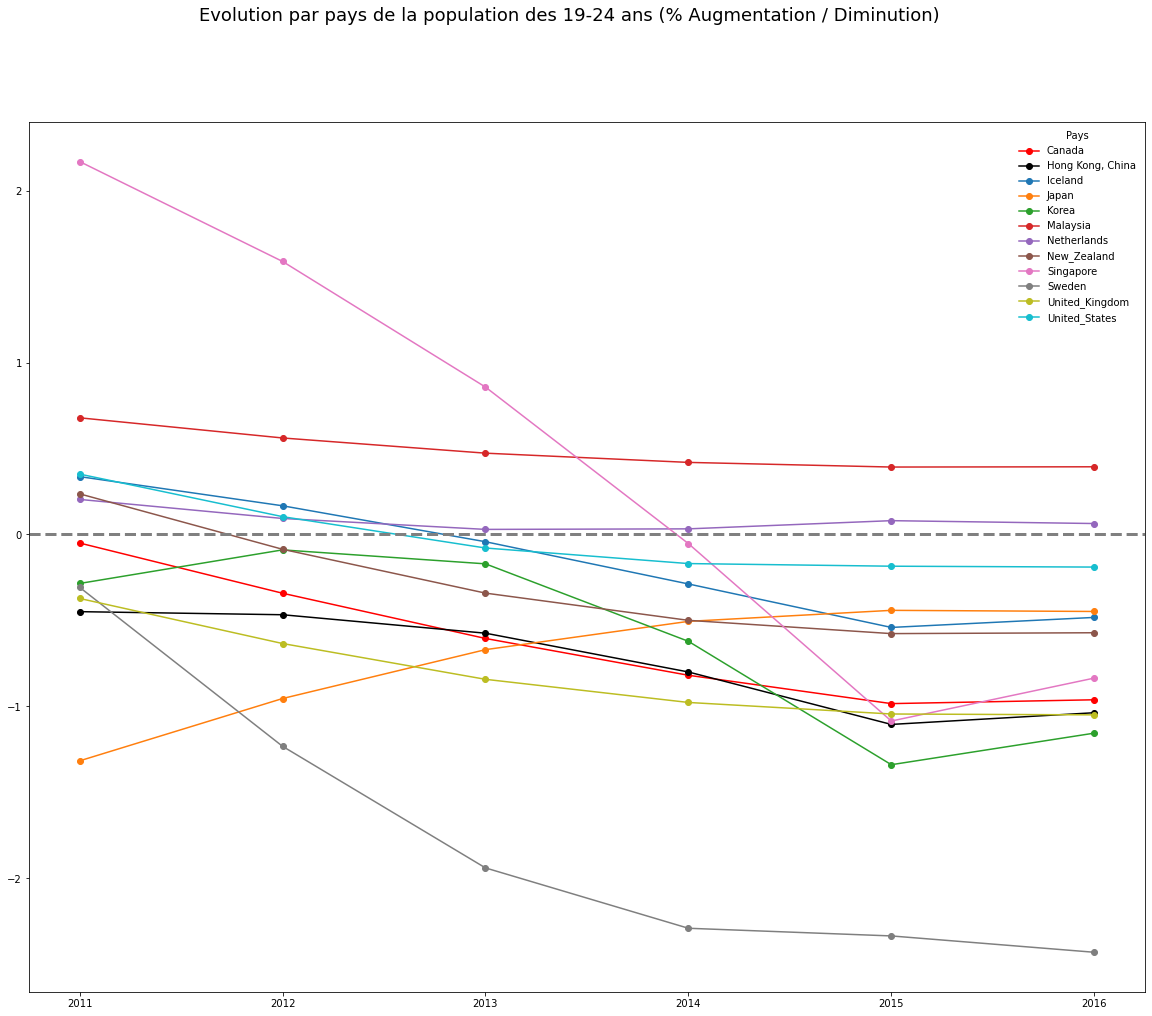

## <span class="bg-info">8 : Conclusion finale<span>

#### <span class="bg-success">8_1 : Proposition d'une liste de 3 pays à privilégier pour une extansion à l'international </span> 
Parmi les 12 pays sélectionnés par score, la zone géographique "Amérique du Nord" se distinguait : le Canada et les Etats Unis faisaient partie du top 12. Un autre pays anglo-saxon se retrouve dans le haut du classement : le Royaume-Uni.
Unité de langue, systèmes éducatifs proches, et stabilité économique les réunissent. Leur population cible est en décroissance, certes, comme le souligne le graphique ci-dessous, mais comme la plupart des 12 pays sélectionnés.
    
 Voici donc la liste proposée:
    
### 1. Royaume-Uni
### 2. Canada
### 3. Etats Unis

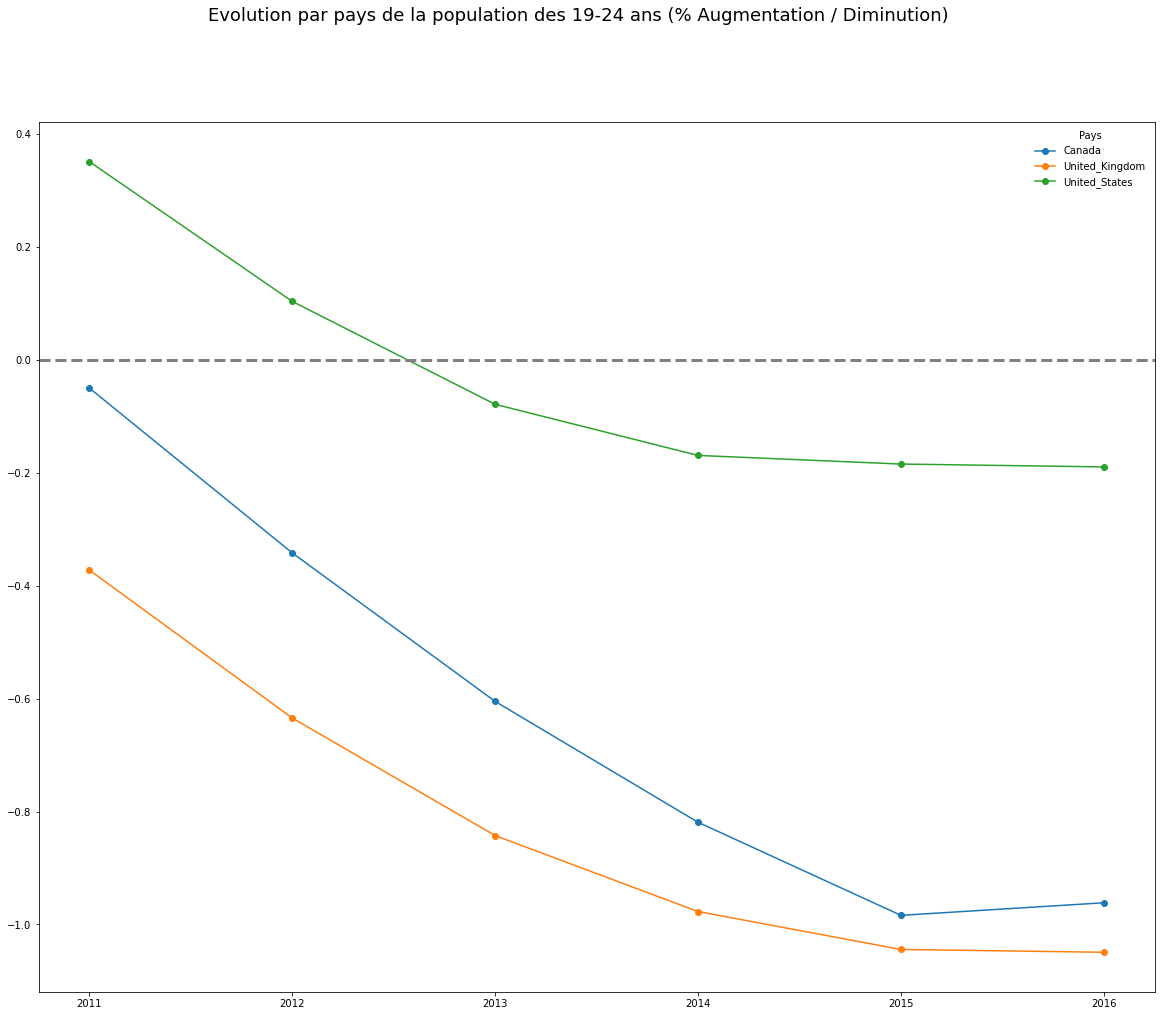

#### <span class="bg-success">8_1 : Pistes réflexives de prolongement </span> 

Nous avions noté la bonne place dans le classement de __l'Asie du Sud Est__ qu'il faudra garder en tête dans l'optique d'une nouvelle analyse. Voici le graphique des 5 pays ou région bien placés dans notre classement.

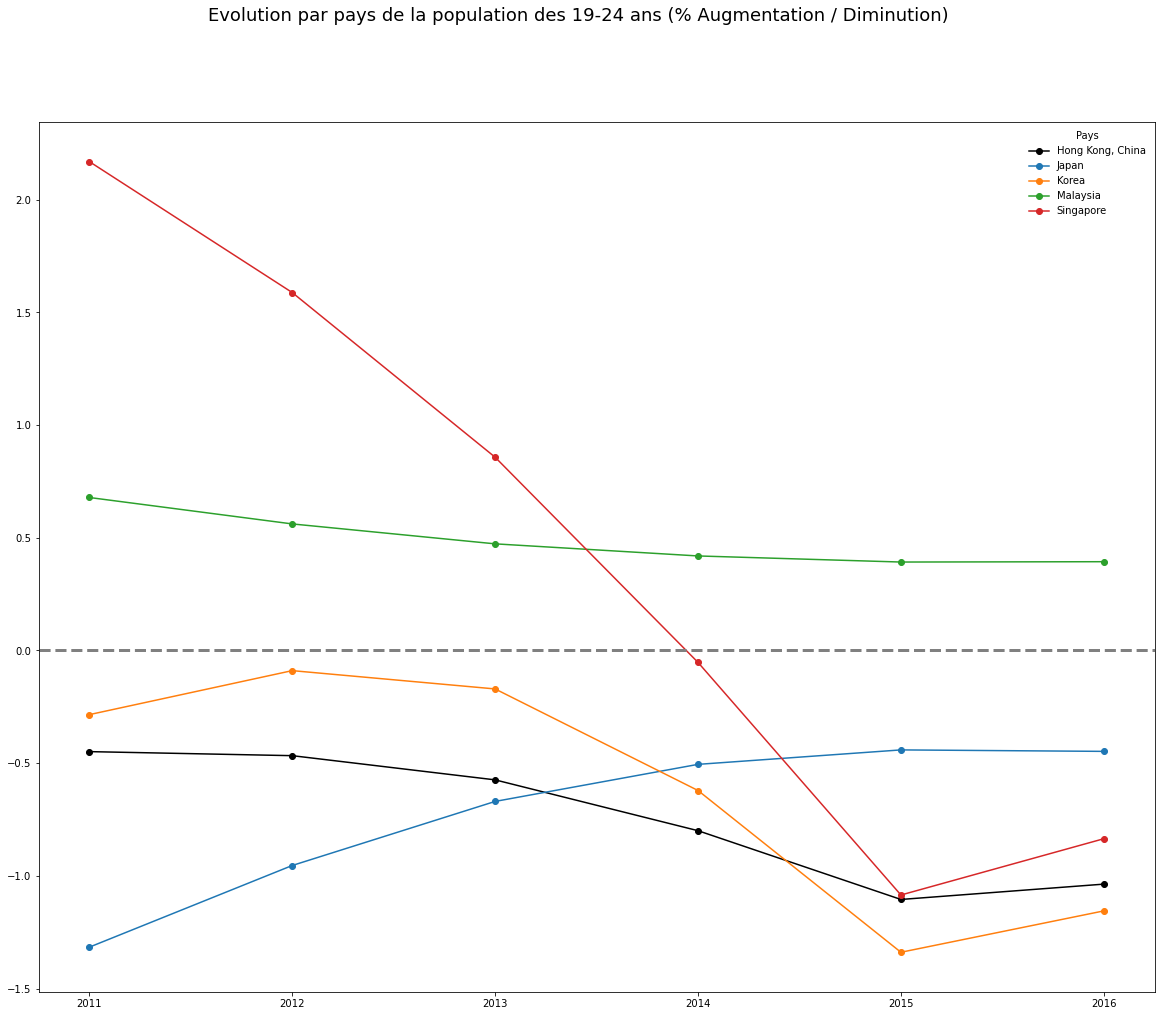